In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import random
import pingouin as pg 

plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2)
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'Verdana'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
ad_discount = pd.read_csv("model_results/prt_val_adaptive_discount_10_10_3.csv")
ad_discount_params = pd.read_csv("model_results/params_val_adaptive_discount_10_10_3.csv")
ad_discount = ad_discount.rename(columns={"diff_mean":"prt_rel_om"})
#prt=prt.groupby(by=["sub_num","galaxy"]).mean().reset_index()
ad_discount['model'] = 'adaptive discount'

mvt = pd.read_csv("model_results/prt_val_MVT_learn.csv")
mvt_params = pd.read_csv("model_results/params_val_MVT_learn.csv")
mvt = mvt.rename(columns={"diff_mean":"prt_rel_om"})
mvt=mvt.groupby(by=["sub_num","galaxy"]).mean().reset_index()
mvt['model'] = 'MVT learn'

td = pd.read_csv("model_results/prt_val_TD.csv")
td_params = pd.read_csv("model_results/params_val_TD.csv")
td = td.rename(columns={"diff_mean":"prt_rel_om"})
td=td.groupby(by=["sub_num","galaxy"]).mean().reset_index()
td['model'] = 'TD'

data =pd.read_csv("data/ref_point_galaxy_dataset_2022_newOpt.csv")
data = data.groupby(by=["sub_num","galaxy"]).mean().reset_index()
data['model'] = 'data'

all_prt = pd.concat([ad_discount,mvt,td,data])
avg= all_prt.groupby(["sub_num","model","galaxy"]).mean().reset_index()


# model comparison

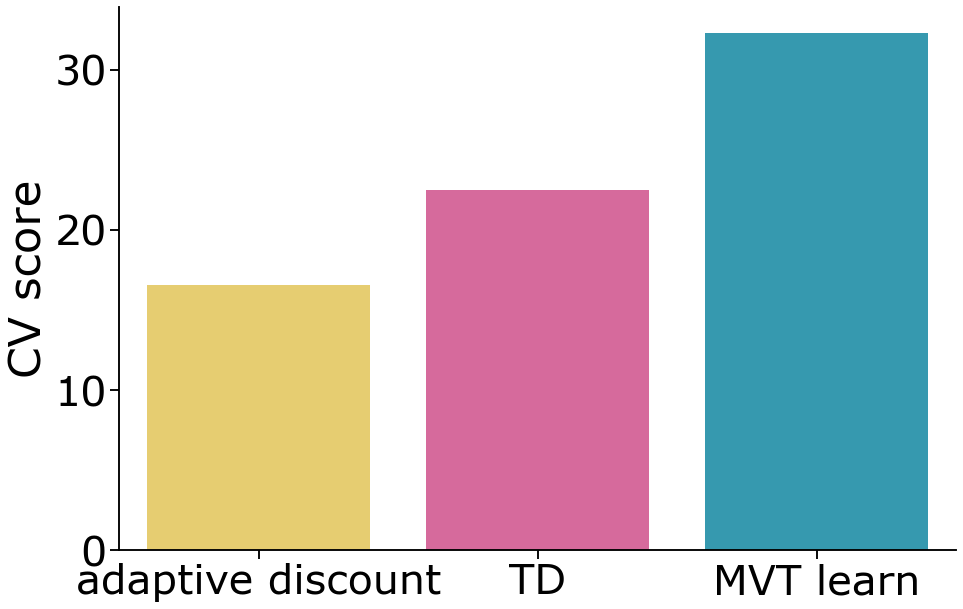

In [5]:
cv=pd.read_csv("model_results/cv_comp.csv")
plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2.5)
palette=["#FFDB58","#ed539b","#1ca9c9",]
g=sns.barplot(x='model',y='cv',ci=None,estimator=np.mean,saturation=0.7,palette=palette,data=cv)

plt.ylabel("CV score")
plt.xticks([0,1,2],['adaptive discount','TD','MVT learn'])
plt.xlabel("")
sns.despine(right=True)
plt.savefig('plots/cv.png',bbox_inches = "tight",dpi=300)

# model validation

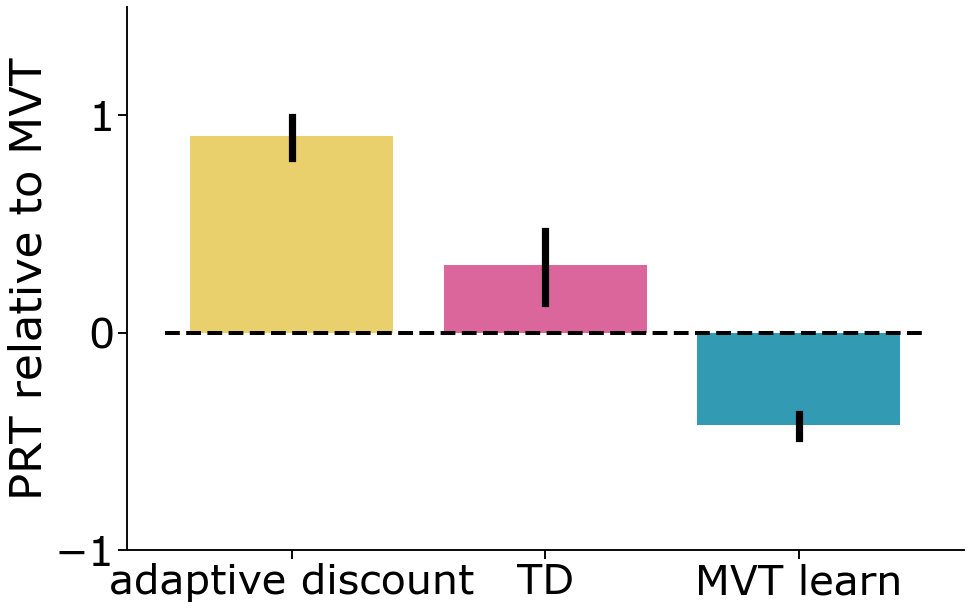

In [7]:
plt.rcParams["figure.figsize"] = (15,10)
sns.set_context('talk',font_scale=2.5)
plt.rcParams["lines.linewidth"] = 4
palette=["#FFDB58","#ed539b","#1ca9c9",]


avg=all_prt.query("model!='data'").groupby(['sub_num','model']).mean().reset_index()
g=sns.barplot(x='model',y='prt_rel_om',order = ['adaptive discount','TD','MVT learn'],ci=68,palette=palette,data=avg)
    
for i,patch in enumerate(g.lines):
    patch.set_color('black')


g.set_ylabel("PRT relative to MVT")
plt.xticks([0,1,2],['adaptive discount','TD','MVT learn'])
plt.plot([-0.5,2.5],[0,0],'k--')
plt.ylim([-1,1.5])
plt.yticks([-1,0,1])
g.set_xlabel("")
sns.despine(right=True)
plt.savefig("plots/model_fit.png",bbox_inches = "tight",dpi=300)

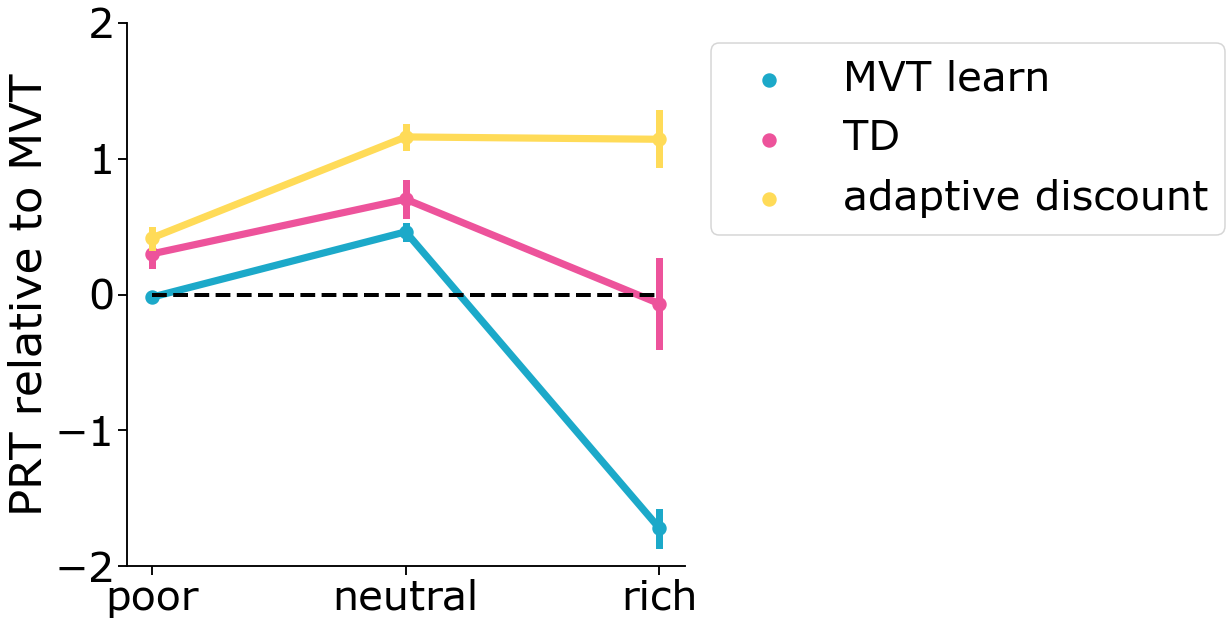

In [272]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2.5)
plt.rcParams["lines.linewidth"] = 4
palette=["#1ca9c9","#ed539b","#FFDB58"]

avg=all_prt.query("model!='data'").groupby(['sub_num','model','galaxy']).mean().reset_index()
g=sns.pointplot(x='galaxy',y='prt_rel_om',hue='model',ci=68,saturation=0.7,palette=palette,linewidth=4,markers='.',errwidth=7,data=avg)
g.set_ylabel("PRT relative to MVT")
plt.xticks([0,1,2],['poor','neutral','rich'])
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.plot([0,2],[0,0],'k--')
plt.ylim([-2,2])
plt.yticks([-2,-1,0,1,2])
g.set_xlabel("")
sns.despine(right=True)
plt.savefig("plots/model_validation.png",bbox_inches = "tight",dpi=300)

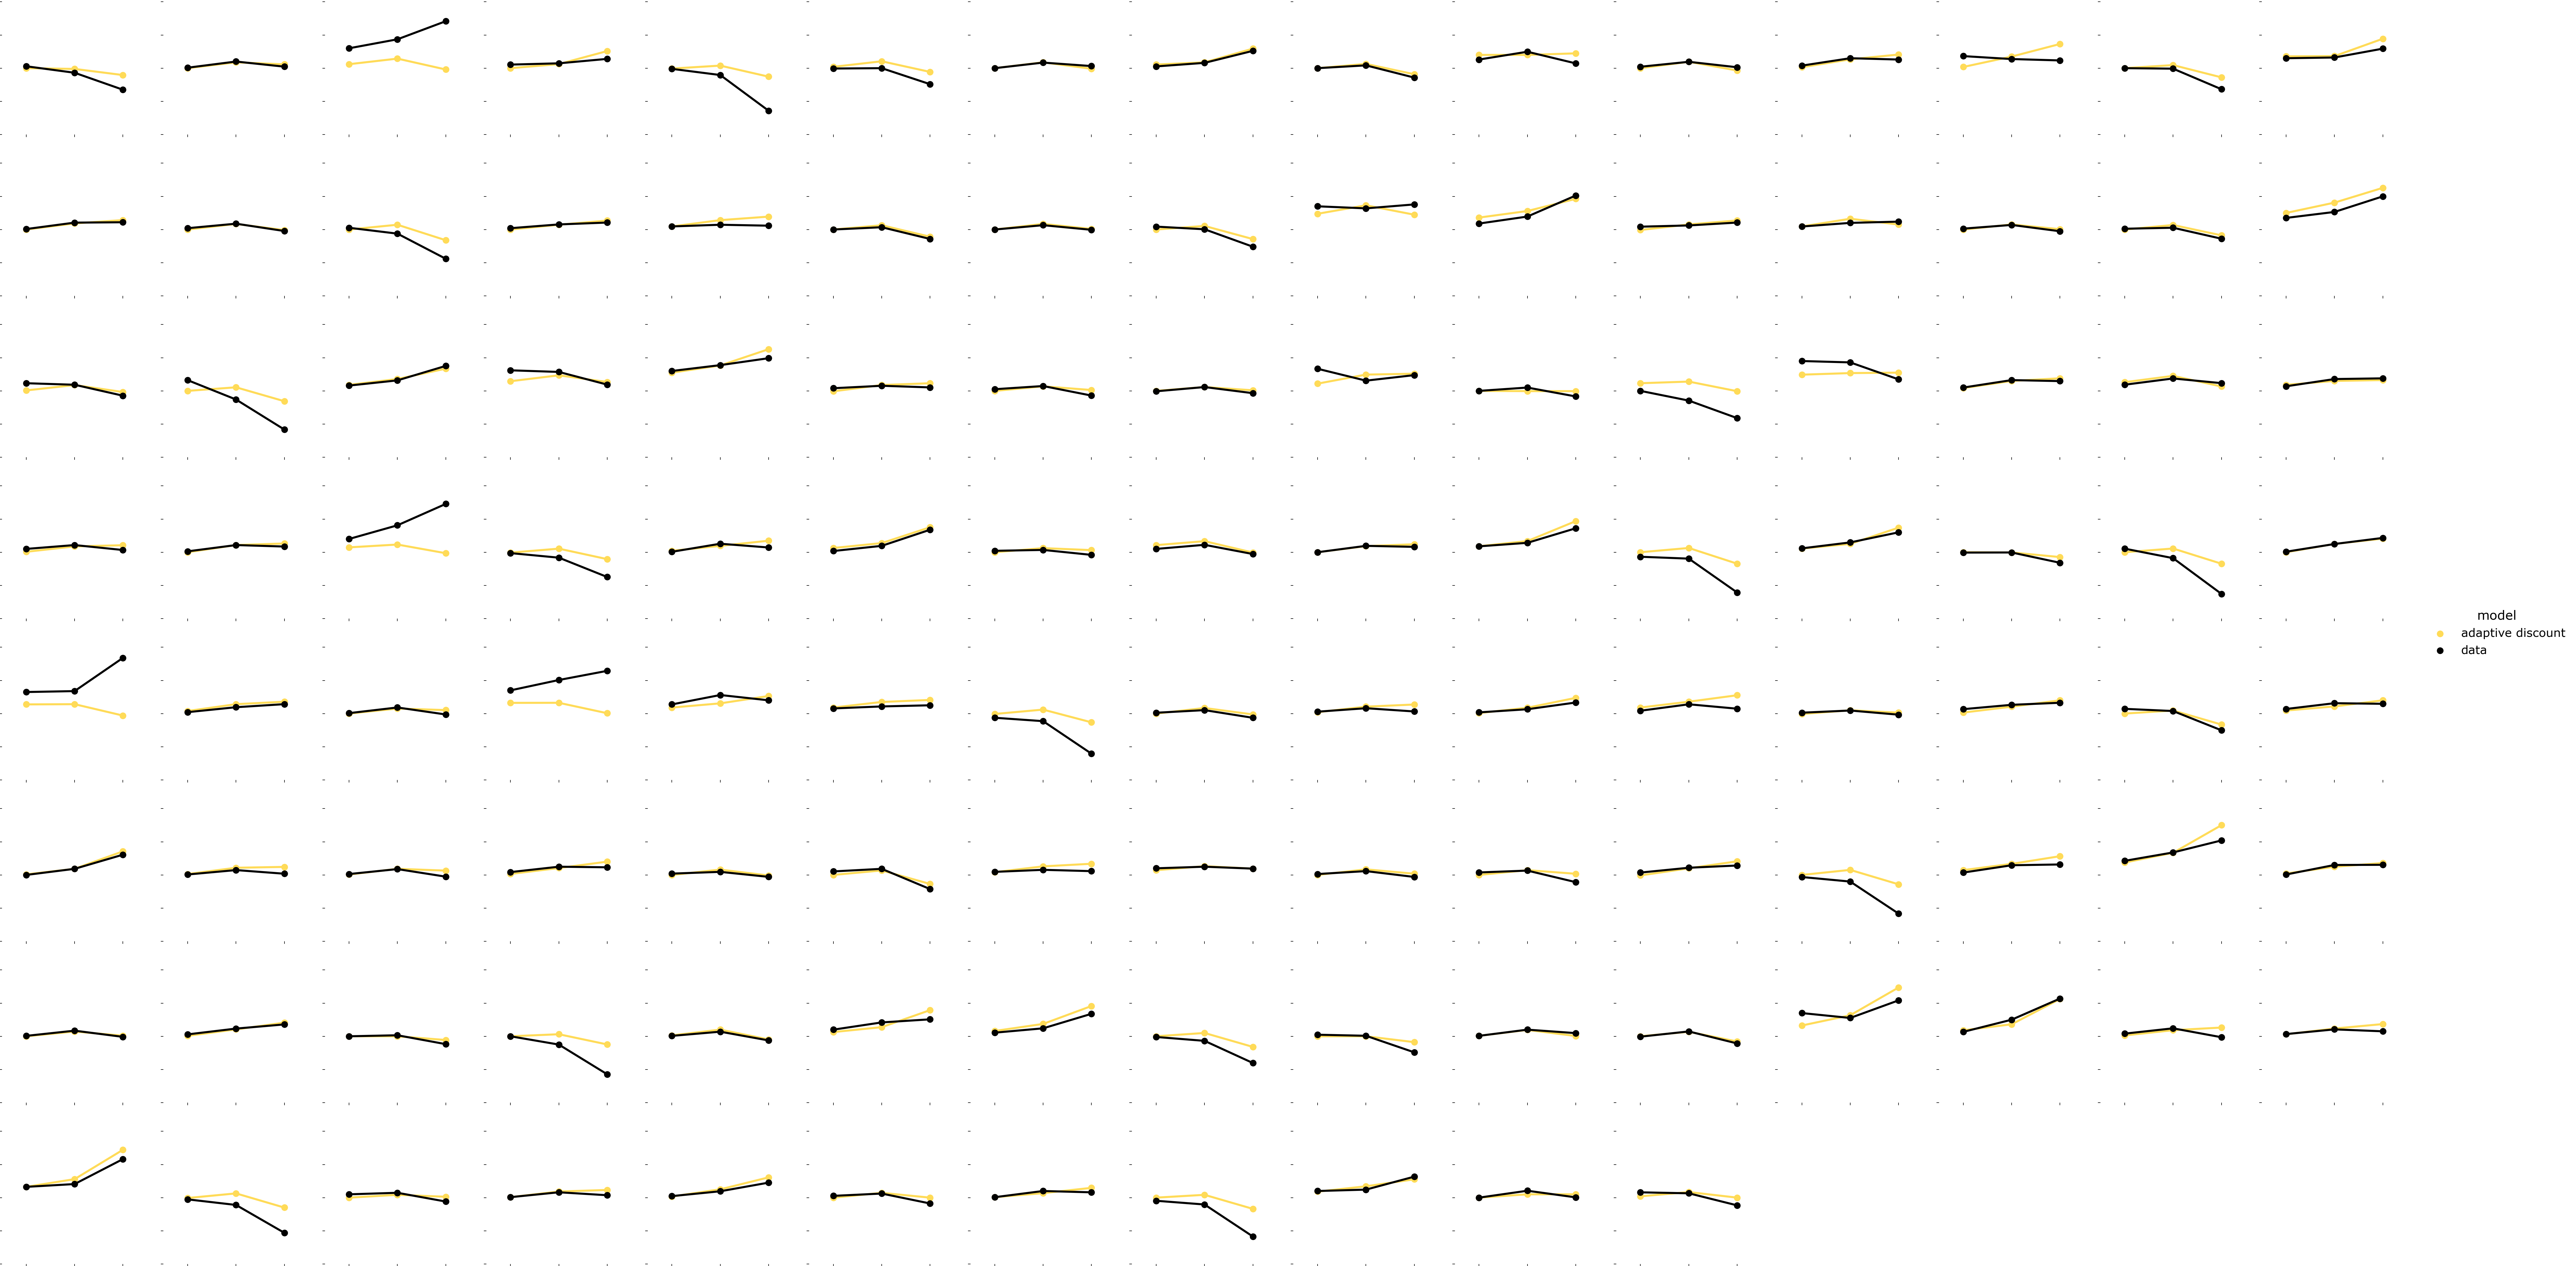

In [10]:
# INDIVIDUAL SUBJECTS 
g = sns.catplot(x="galaxy",y="prt_rel_om",col='sub_num',data=all_prt.query("model !='TD' & model !='MVT learn'"),hue="model", kind="point",height=8,palette=[palette[0],"black"],col_wrap=15,margin_titles=True)
g.despine(top=True,left=True,right=True,bottom=True)
g.set_titles("")
g.set_ylabels("")
g.set_xlabels("")
g.set_xticklabels([])
g.set_yticklabels([])

plt.savefig('plots/model_compare_data_indivual_sub_adaptive_discount.png',dpi=150,bbox_inches = "tight")

# parameter distributions

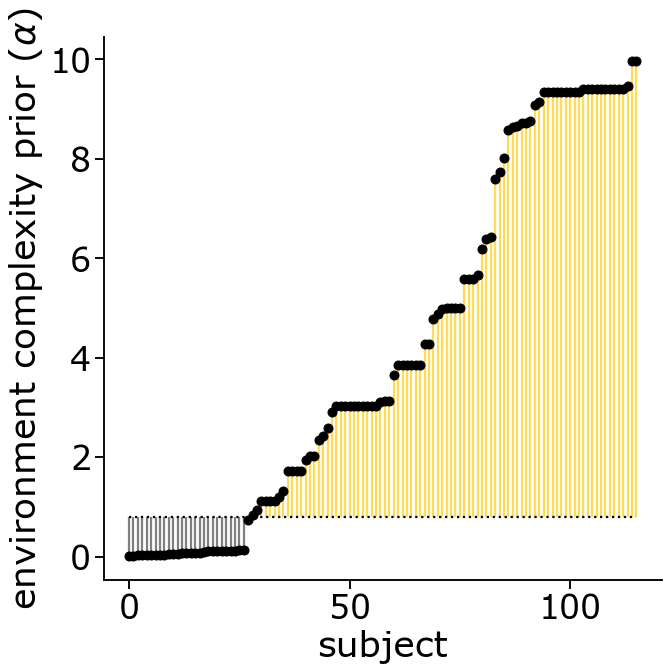

In [13]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=2)
my_pal =["grey"]*28 + [palette[0]]*88

avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()#.query("sub_num not in @to_drop")
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['alpha'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=0.8,use_line_collection=True)
plt.setp(stemlines, 'color', my_pal)#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel(r'environment complexity prior ($\alpha$)')
plt.xlabel("subject")
sns.despine(right=True)
plt.savefig('plots/alpha.png',bbox_inches = "tight",dpi=300)

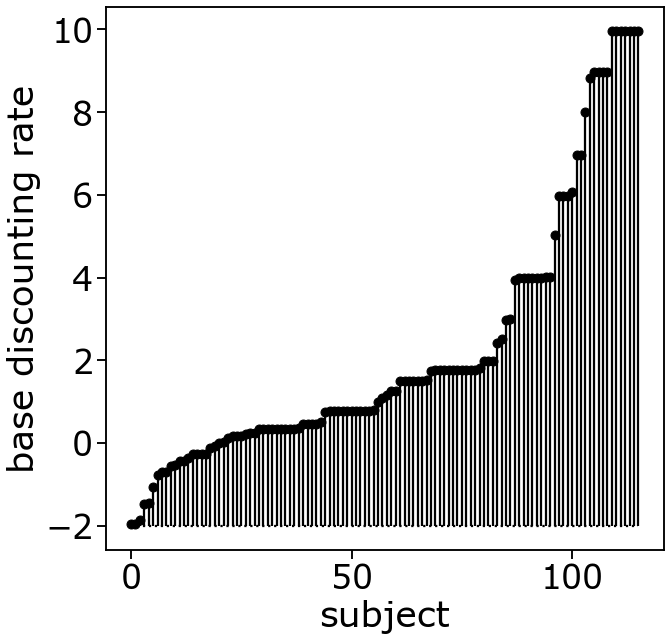

In [14]:
avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['gamma_base'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=-2,use_line_collection=True)
plt.setp(stemlines, 'color', 'k')#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel('base discounting rate')
plt.xlabel("subject")
plt.savefig('plots/gamma_base.png',bbox_inches = "tight",dpi=300)

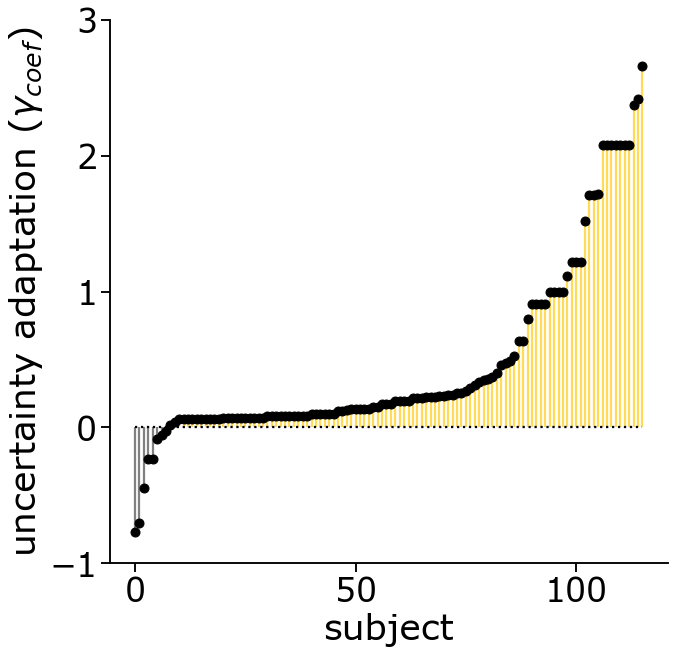

In [18]:
plt.rcParams["figure.figsize"] = (10,10)
my_pal =["grey"]*8 + [palette[0]]*108
avg = ad_discount_params.groupby(by="sub_num").mean().reset_index()
unsort_avg = pd.melt(avg,id_vars=['sub_num'],value_vars=['gamma_coef'],var_name='param',value_name='value')
sort_avg=unsort_avg.sort_values(by='value').value.to_list()
subject = list(range(len(avg.sub_num)))

markerline, stemlines, baseline=plt.stem(subject, sort_avg, markerfmt = 'ro', linefmt='r-', basefmt = 'r:', bottom=0,use_line_collection=True)
plt.setp(stemlines, 'color', my_pal)#pal[3]
plt.setp(markerline, 'color', 'k')
plt.setp(baseline, 'color', 'k')
plt.ylabel(r'uncertainty adaptation ($\gamma_{coef}$)')
plt.xlabel("subject")
plt.ylim([-1,3])
plt.yticks([-1,0,1,2,3])
sns.despine(right=True)

plt.savefig('plots/gamma_coef.png',bbox_inches = "tight",dpi=300)

# untransform parameters from bounds to be normally distributed

In [21]:
ad_discount_params['alphaz']=-np.log(-1 + (10/np.array(ad_discount_params['alpha'])))
ad_discount_params['gamma_basez']=-np.log(-1 + ((12)/(np.array(ad_discount_params['gamma_base']+2))))
ad_discount_params['gamma_coefz']=-np.log(-1 + (6/(np.array(ad_discount_params['gamma_coef']+3))))
ad_discount_params.to_csv("model_results/untransformed_params_2022.csv")